In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
#from src.algorithms import *
#import torch
import sklearn
import PIL
from PIL import Image
%load_ext autoreload

In [62]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

In [63]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [64]:
#filename = "2023913_1110.h5" #original
#filename = "202310 9_1132.h5" #pedras mais pequenas
#filename='202310 9_1420.h5'
filename1='20231130_ 858.h5' #pedra potencia 30%
filename2='20231129_15 9.h5' #pedra potencia 40%
filename3='20231130_1053.h5' #pedra potencia 60%
spectrum_raman_1, wavelengths_raman, exp_properties = Raman_data_loader(filename1) #P=30%
spectrum_raman_2, wavelengths_raman, exp_properties = Raman_data_loader(filename2)# P=40%
spectrum_raman_3, wavelengths_raman, exp_properties = Raman_data_loader(filename3)#P=60%

In [65]:
exp_properties

{'step_size': 0.5,
 'speed': array([b'5.000', b'5.000'], dtype=object),
 'n_points': array([100,  50])}

In [66]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [67]:
spectra=np.array([spectrum_raman_1,spectrum_raman_2,spectrum_raman_3])


In [68]:
lam = 1e2
p = 1e-1
pro_data_geral=[]
for spect in spectra:
    spectrum_raman=spect
    pro_data = 1*spectrum_raman
    for i in tqdm(range(0, pro_data.shape[0])):
        for j in range(0, pro_data.shape[1]):
            # print(i,j,end='\r')
            spec = 1 * pro_data[i, j, :]
            pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)
    pro_data_geral.append(pro_data)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.01s/it]


In [71]:
pro_data_geral=np.array(pro_data_geral)
pro_data_geral.shape

(3, 100, 50, 1024)

In [72]:
pro_data_norm_geral=pro_data_geral.copy()


for spect in range(3):
    for i in range(0,pro_data.shape[0]):
        for j in range(0,pro_data.shape[1]):
            spec = 1 * pro_data_geral[spect,i,j, :]
            sum_spec=np.sum(spec)
            if sum_spec==0:
                pro_data_norm_geral[spect,i,j,:]=0
            else:
                pro_data_norm_geral[spect,i,j,:]=spec/sum_spec

In [73]:
pro_data_norm_geral.shape

(3, 100, 50, 1024)

In [74]:
offset_l = 31
offset_m = 328

mask1 = pro_data_norm_geral[0,:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)
mask2 = pro_data_norm_geral[1,:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)
mask3 = pro_data_norm_geral[2,:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)


In [75]:
mask_geral=np.array([mask1,mask2,mask3])

## HDR

In [148]:
med=np.zeros(mask2.shape[0])
std=np.zeros(mask2.shape[0])
for i in range(mask2.shape[0]): #a cada posição calcula a média de todos os comprimentos de onda
    med[i]=np.mean(mask2[i][:])
    std[i]=np.std(mask2[i][:])
    
#a cada comprimento de onda ve se esta acima ou abaixo da media
final_mask=mask2.copy()
for i in range(mask2.shape[0]):
    
    for j in range(mask2.shape[1]):
        if mask2[i,j]>=med[i]+3*std[i]: #saturado
            final_mask[i,j]=0.6*mask1[i,j]+0.2*mask2[i,j]+0.2*mask3[i,j]
              
        elif mask2[i,j]<=med[i]+3*std[i]: #pouco sinal
            final_mask[i,j]=0.6*mask3[i,j]+0.2*mask1[i,j]+0.2*mask1[i,j]
        else:
            final_mask[i,j]=0.6*mask2[i,j]+0.2*mask3[i,j]+0.2*mask1[i,j]
            
            
            

In [172]:
threshold = 0.0007
mask=final_mask
mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])



In [173]:

mask_min_max = np.array([(mask_t[i, :] - mask_t[i, :].min(axis = 0)+ 1e-5)/(mask_t[i, :].max(axis = 0) - mask_t[i, :].min(axis = 0) + 1e-5) for i in range(mask_t.shape[0])])
masks = np.array([sklearn.cluster.KMeans(n_clusters = 2, init = init_k, random_state = 100).fit_predict(mask_min_max[i, :].reshape(-1, 1)) for i in range(mask_min_max.shape[0])])



C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._chec

In [174]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

<IPython.core.display.Javascript object>


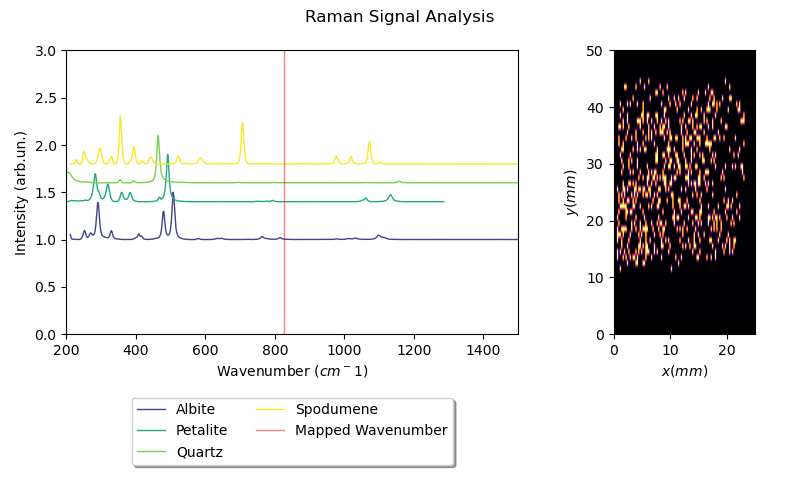

Albite
Background
Background not found
Petalite
Quartz
Spodumene


In [175]:
%matplotlib notebook
fig, ax = subplots(1, 2, figsize = (8, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('Raman Signal Analysis')

axs = ax[0]
minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        axs.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec), lw = 1, color = cm.viridis((i+1)/len(mineral_list)), label = mineral)
    except:
        print(mineral + ' not found')
axs.set_ylim(0,1+0.2*(i+1)+1)
axs.set_xlim(200,1500)
    
axs.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1.0), ncol = 2, fancybox = True, shadow = True)
wn = 120
line = axs.axvline(wavelengths_raman[offset_l:offset_m][wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavenumber')
axs.set_xlabel(r'Wavenumber $(cm^-1)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(loc='upper center', bbox_to_anchor = (0.5, -0.2), ncol = 2, fancybox = True, shadow = True)

axs = ax[1]
axs.imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno, extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                                                        0, exp_properties['step_size']*exp_properties['n_points'][0]])
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(masks.T.reshape(pro_data.shape[0], pro_data.shape[1], -1)[:, :, wn].T, cmap = cm.inferno,
                      extent = [0, exp_properties['step_size']*exp_properties['n_points'][1],
                            0, exp_properties['step_size']*exp_properties['n_points'][0]],
                     interpolation = 'none')
    line.set_xdata(wavelengths_raman[offset_l:offset_m][wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths_raman[offset_l:offset_m], ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [176]:

kmeans = sklearn.cluster.KMeans(n_clusters = 5)
a=kmeans.fit_predict(masks)

C:\Users\zecar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [177]:
# labels = kmeans.labels_.cpu()
labels = kmeans.labels_

<IPython.core.display.Javascript object>


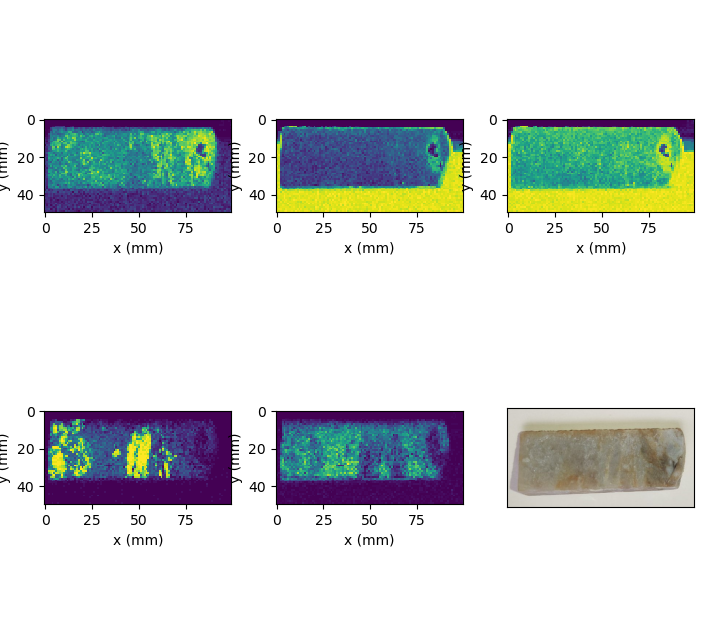

In [179]:

fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()

image=Image.open('segunda_pedra - Cópia.JPG')

ax[-1,-1].imshow(image)
ax[-1,-1].set_xticks([])
ax[-1,-1].set_yticks([])
#savefig('segundapedra_comb3masks.JPG',dpi=500)